##### Librerías

In [2]:
import os
import cv2
import time
import numpy as np
import pandas as pd

from typing import NamedTuple
from mediapipe.python.solutions.holistic import Holistic
from mediapipe.python.solutions.holistic import POSE_CONNECTIONS, HAND_CONNECTIONS, FACEMESH_CONTOURS
from mediapipe.python.solutions.drawing_utils import draw_landmarks, DrawingSpec
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import load_model

import pygame
from gtts import gTTS
from time import sleep
from keras.models import Sequential
from keras.layers import LSTM, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical



pygame 2.5.2 (SDL 2.28.3, Python 3.12.4)
Hello from the pygame community. https://www.pygame.org/contribute.html


##### Rutas

In [3]:
ROOT_PATH = os.path.join(os.getcwd())
#ROOT_PATH = "C:\Users\Admin\Desktop\Proyecto Final\Ejemplo"
#FRAME_ACTIONS_PATH = os.path.join(ROOT_PATH,"frames_prueba")
FRAME_ACTIONS_PATH = os.path.join("G:\\","frames_train_seleccion3")
VIDEO_PATH = "1"
DATA_PATH = os.path.join(ROOT_PATH, "data0")
MODELS_PATH = os.path.join(ROOT_PATH, "models")

#PARAMENTROS
MAX_LENGTH_FRAMES = 30
LENGTH_KEYPOINTS = 258 #1662
MIN_LENGTH_FRAMES = 5
MODEL_NAME = "modelfinal0.keras"

# SHOW IMAGE PARAMETERS
FONT = cv2.FONT_HERSHEY_PLAIN
FONT_SIZE = 1.5
FONT_POS = (5, 30)

##### Herramientas

In [4]:
def create_folder(path):
    if not os.path.exists(path):
        os.makedirs(path)

def there_hand(results: NamedTuple) -> bool:
    return results.left_hand_landmarks or results.right_hand_landmarks

def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False
    results = model.process(image) 
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return image, results

def get_actions(path):
    out = []
    for action in os.listdir(path):
        name, ext = os.path.splitext(action)
        if ext == ".h5":
            out.append(name)
    return out


def text_to_speech(text):
    tts = gTTS(text=text, lang='en')
    filename = "speech.mp3"
    tts.save(filename)
    
    pygame.init()
    pygame.mixer.init()
    pygame.mixer.music.load(filename)
    pygame.mixer.music.play()
    while pygame.mixer.music.get_busy():
        sleep(1)

    pygame.mixer.quit()
    pygame.quit()

    os.remove(filename)




##### Captura de muestras

In [5]:
def configurar_resolucion(camara):
    camara.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
    camara.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)

def draw_keypoints(image, results):
    
    draw_landmarks(
        image,
        results.pose_landmarks,
        POSE_CONNECTIONS,
        DrawingSpec(color=(80, 22, 10), thickness=2, circle_radius=4),
        DrawingSpec(color=(80, 44, 121), thickness=2, circle_radius=2),
    )
    draw_landmarks(
        image,
        results.face_landmarks,
        FACEMESH_CONTOURS,
        DrawingSpec(color=(80, 110, 10), thickness=1, circle_radius=1),
        DrawingSpec(color=(80, 256, 121), thickness=1, circle_radius=1),
    )
   
    draw_landmarks(
        image,
        results.left_hand_landmarks,
        HAND_CONNECTIONS,
        DrawingSpec(color=(121, 22, 76), thickness=2, circle_radius=4),
        DrawingSpec(color=(121, 44, 250), thickness=2, circle_radius=2),
    )
    
    draw_landmarks(
        image,
        results.right_hand_landmarks,
        HAND_CONNECTIONS,
        DrawingSpec(color=(245, 117, 66), thickness=2, circle_radius=4),
        DrawingSpec(color=(245, 66, 230), thickness=2, circle_radius=2),
    )

def save_frames(frames, output_folder):
    for num_frame, frame in enumerate(frames):
        frame_path = os.path.join(output_folder, f"{num_frame + 1}.jpg")
        cv2.imwrite(frame_path, cv2.cvtColor(frame, cv2.COLOR_BGR2BGRA))

##### Metricas

In [6]:
import math
from scipy.spatial import ConvexHull
from mediapipe.python.solutions.hands import HandLandmark

def thumb_position_metric(hand_landmarks):
    if hand_landmarks:
        thumb_tip = hand_landmarks.landmark[HandLandmark.THUMB_TIP]
        base_index = hand_landmarks.landmark[HandLandmark.INDEX_FINGER_MCP]
        return np.linalg.norm(np.array([thumb_tip.x, thumb_tip.y]) - np.array([base_index.x, base_index.y]))
    return 0.0

def fingers_extended(hand_landmarks):
    if hand_landmarks:
        fingers_tips = [
            HandLandmark.INDEX_FINGER_TIP, 
            HandLandmark.MIDDLE_FINGER_TIP, 
            HandLandmark.RING_FINGER_TIP, 
            HandLandmark.PINKY_TIP
        ]
        fingers_pips = [
            HandLandmark.INDEX_FINGER_PIP, 
            HandLandmark.MIDDLE_FINGER_PIP, 
            HandLandmark.RING_FINGER_PIP, 
            HandLandmark.PINKY_PIP
        ]
        count = 0
        for tip, pip in zip(fingers_tips, fingers_pips):
            if hand_landmarks.landmark[tip].y < hand_landmarks.landmark[pip].y:
                count += 1
        return count
    return 0

def distance_between_fingers(hand_landmarks):
    if hand_landmarks:
        distances = []
        fingers_tips = [
            HandLandmark.THUMB_TIP,
            HandLandmark.INDEX_FINGER_TIP,
            HandLandmark.MIDDLE_FINGER_TIP,
            HandLandmark.RING_FINGER_TIP,
            HandLandmark.PINKY_TIP
        ]
        for i in range(len(fingers_tips)):
            for j in range(i + 1, len(fingers_tips)):
                tip1 = hand_landmarks.landmark[fingers_tips[i]]
                tip2 = hand_landmarks.landmark[fingers_tips[j]]
                distance = np.linalg.norm(np.array([tip1.x, tip1.y]) - np.array([tip2.x, tip2.y]))
                distances.append(distance)
        return distances
    return [0.0] * 10

def angle_between(v1, v2):
    """ Calculate the angle in radians between vectors 'v1' and 'v2' """
    v1_u = v1 / np.linalg.norm(v1)
    v2_u = v2 / np.linalg.norm(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

def angles_between_fingers(hand_landmarks):
    if hand_landmarks:
        fingers_indices = [
            HandLandmark.THUMB_TIP,
            HandLandmark.INDEX_FINGER_TIP,
            HandLandmark.MIDDLE_FINGER_TIP,
            HandLandmark.RING_FINGER_TIP,
            HandLandmark.PINKY_TIP
        ]
        wrist = hand_landmarks.landmark[HandLandmark.WRIST]
        angles = []
        for i in range(len(fingers_indices) - 1):
            finger1 = hand_landmarks.landmark[fingers_indices[i]]
            finger2 = hand_landmarks.landmark[fingers_indices[i + 1]]
            v1 = np.array([finger1.x - wrist.x, finger1.y - wrist.y])
            v2 = np.array([finger2.x - wrist.x, finger2.y - wrist.y])
            angle = angle_between(v1, v2)
            angles.append(angle)
        return angles
    return [0.0] * 4

def finger_curvature(hand_landmarks):
    if hand_landmarks:
        curvatures = []
        fingers_joints = [
            [HandLandmark.INDEX_FINGER_TIP, HandLandmark.INDEX_FINGER_DIP, HandLandmark.INDEX_FINGER_PIP],
            [HandLandmark.MIDDLE_FINGER_TIP, HandLandmark.MIDDLE_FINGER_DIP, HandLandmark.MIDDLE_FINGER_PIP],
            [HandLandmark.RING_FINGER_TIP, HandLandmark.RING_FINGER_DIP, HandLandmark.RING_FINGER_PIP],
            [HandLandmark.PINKY_TIP, HandLandmark.PINKY_DIP, HandLandmark.PINKY_PIP]
        ]
        for joints in fingers_joints:
            tip = hand_landmarks.landmark[joints[0]]
            dip = hand_landmarks.landmark[joints[1]]
            pip = hand_landmarks.landmark[joints[2]]
            curvature = (np.linalg.norm(np.array([tip.x - dip.x, tip.y - dip.y])) +
                         np.linalg.norm(np.array([dip.x - pip.x, dip.y - pip.y])))
            curvatures.append(curvature)
        return curvatures
    return [0.0] * 4

def distance_wrist_to_fingers(hand_landmarks):
    if hand_landmarks:
        distances = []
        wrist = hand_landmarks.landmark[HandLandmark.WRIST]
        fingers_tips = [
            HandLandmark.THUMB_TIP,
            HandLandmark.INDEX_FINGER_TIP,
            HandLandmark.MIDDLE_FINGER_TIP,
            HandLandmark.RING_FINGER_TIP,
            HandLandmark.PINKY_TIP
        ]
        for tip in fingers_tips:
            finger_tip = hand_landmarks.landmark[tip]
            distance = np.linalg.norm(np.array([finger_tip.x - wrist.x, finger_tip.y - wrist.y]))
            distances.append(distance)
        return distances
    return [0.0] * 5

def hand_symmetry(left_hand_landmarks, right_hand_landmarks):
    if left_hand_landmarks and right_hand_landmarks:
        left_distances = distance_between_fingers(left_hand_landmarks)
        right_distances = distance_between_fingers(right_hand_landmarks)
        symmetry = np.mean([abs(ld - rd) for ld, rd in zip(left_distances, right_distances)])
        return symmetry
    return 0.0

previous_landmarks = None

def finger_movement_speed(hand_landmarks, previous_landmarks, delta_time):
    if hand_landmarks and previous_landmarks:
        speeds = []
        for tip in [
            HandLandmark.THUMB_TIP,
            HandLandmark.INDEX_FINGER_TIP,
            HandLandmark.MIDDLE_FINGER_TIP,
            HandLandmark.RING_FINGER_TIP,
            HandLandmark.PINKY_TIP
        ]:
            current_tip = hand_landmarks.landmark[tip]
            previous_tip = previous_landmarks.landmark[tip]
            distance = np.linalg.norm(np.array([current_tip.x - previous_tip.x, current_tip.y - previous_tip.y]))
            speed = distance / delta_time
            speeds.append(speed)
        return speeds
    return [0.0] * 5

def hand_area(hand_landmarks):
    if hand_landmarks:
        points = np.array([
            [hand_landmarks.landmark[tip].x, hand_landmarks.landmark[tip].y]
            for tip in [
                HandLandmark.THUMB_TIP,
                HandLandmark.INDEX_FINGER_TIP,
                HandLandmark.MIDDLE_FINGER_TIP,
                HandLandmark.RING_FINGER_TIP,
                HandLandmark.PINKY_TIP,
                HandLandmark.WRIST
            ]
        ])
        hull = ConvexHull(points)
        return hull.volume  # or hull.area if you want the 2D area
    return 0.0

def finger_length_ratio(hand_landmarks):
    if hand_landmarks:
        lengths = []
        fingers_joints = [
            [HandLandmark.THUMB_TIP, HandLandmark.THUMB_IP, HandLandmark.THUMB_MCP],
            [HandLandmark.INDEX_FINGER_TIP, HandLandmark.INDEX_FINGER_DIP, HandLandmark.INDEX_FINGER_PIP, HandLandmark.INDEX_FINGER_MCP],
            [HandLandmark.MIDDLE_FINGER_TIP, HandLandmark.MIDDLE_FINGER_DIP, HandLandmark.MIDDLE_FINGER_PIP, HandLandmark.MIDDLE_FINGER_MCP],
            [HandLandmark.RING_FINGER_TIP, HandLandmark.RING_FINGER_DIP, HandLandmark.RING_FINGER_PIP, HandLandmark.RING_FINGER_MCP],
            [HandLandmark.PINKY_TIP, HandLandmark.PINKY_DIP, HandLandmark.PINKY_PIP, HandLandmark.PINKY_MCP]
        ]
        for joints in fingers_joints:
            length = sum(np.linalg.norm(
                np.array([hand_landmarks.landmark[joints[i]].x, hand_landmarks.landmark[joints[i]].y]) -
                np.array([hand_landmarks.landmark[joints[i+1]].x, hand_landmarks.landmark[joints[i+1]].y])
            ) for i in range(len(joints) - 1))
            lengths.append(length)
        return lengths
    return [0.0] * 5

def hand_orientation(hand_landmarks):
    if hand_landmarks:
        wrist = hand_landmarks.landmark[HandLandmark.WRIST]
        middle_finger_mcp = hand_landmarks.landmark[HandLandmark.MIDDLE_FINGER_MCP]
        vector = np.array([middle_finger_mcp.x - wrist.x, middle_finger_mcp.y - wrist.y])
        orientation = np.arctan2(vector[1], vector[0])
        return orientation
    return 0.0

def distance_between_fingertips(hand_landmarks):
    if hand_landmarks:
        distances = []
        fingers_tips = [
            HandLandmark.THUMB_TIP,
            HandLandmark.INDEX_FINGER_TIP,
            HandLandmark.MIDDLE_FINGER_TIP,
            HandLandmark.RING_FINGER_TIP,
            HandLandmark.PINKY_TIP
        ]
        for i in range(len(fingers_tips)):
            for j in range(i + 1, len(fingers_tips)):
                tip1 = hand_landmarks.landmark[fingers_tips[i]]
                tip2 = hand_landmarks.landmark[fingers_tips[j]]
                distance = np.linalg.norm(np.array([tip1.x, tip1.y]) - np.array([tip2.x, tip2.y]))
                distances.append(distance)
        return distances
    return [0.0] * 10  # 5 choose 2 = 10 distances

def calculate_keypoints_variation(keypoints_sequence):
    variations = []
    for i in range(1, len(keypoints_sequence)):
        prev_keypoints = keypoints_sequence[i-1]
        current_keypoints = keypoints_sequence[i]
        variation = np.linalg.norm(np.array(current_keypoints) - np.array(prev_keypoints))
        variations.append(variation)
    return variations

def is_static_or_moving(variations, threshold=0.1):
    mean_variation = np.mean(variations)
    return 1 if mean_variation < threshold else 0


def extract_metrics(results, previous_results, delta_time):
    metrics = {
        'thumb_distance_left': 0.0,
        'thumb_distance_right': 0.0,
        'fingers_extended_left': 0,
        'fingers_extended_right': 0,
        'finger_distances_left': [0.0] * 10,
        'finger_distances_right': [0.0] * 10,
        'angles_between_fingers_left': [0.0] * 4,
        'angles_between_fingers_right': [0.0] * 4,
        'finger_curvature_left': [0.0] * 4,
        'finger_curvature_right': [0.0] * 4,
        'distance_wrist_to_fingers_left': [0.0] * 5,
        'distance_wrist_to_fingers_right': [0.0] * 5,
        'hand_symmetry': 0.0,
        'finger_movement_speed_left': [0.0] * 5,
        'finger_movement_speed_right': [0.0] * 5,
        'hand_area_left': 0.0,
        'hand_area_right': 0.0,
        'finger_length_ratio_left': [0.0] * 5,
        'finger_length_ratio_right': [0.0] * 5,
        'hand_orientation_left': 0.0,
        'hand_orientation_right': 0.0,
        'fingertip_distances_left': [0.0] * 10,
        'fingertip_distances_right': [0.0] * 10
    }
    if results.left_hand_landmarks:
        metrics['thumb_distance_left'] = thumb_position_metric(results.left_hand_landmarks)
        metrics['fingers_extended_left'] = fingers_extended(results.left_hand_landmarks)
        metrics['finger_distances_left'] = distance_between_fingers(results.left_hand_landmarks)
        metrics['angles_between_fingers_left'] = angles_between_fingers(results.left_hand_landmarks)
        metrics['finger_curvature_left'] = finger_curvature(results.left_hand_landmarks)
        metrics['distance_wrist_to_fingers_left'] = distance_wrist_to_fingers(results.left_hand_landmarks)
        metrics['hand_area_left'] = hand_area(results.left_hand_landmarks)
        metrics['finger_length_ratio_left'] = finger_length_ratio(results.left_hand_landmarks)
        metrics['hand_orientation_left'] = hand_orientation(results.left_hand_landmarks)
        metrics['fingertip_distances_left'] = distance_between_fingertips(results.left_hand_landmarks)
        if previous_results:
            metrics['finger_movement_speed_left'] = finger_movement_speed(results.left_hand_landmarks, previous_results.left_hand_landmarks, delta_time)
    if results.right_hand_landmarks:
        metrics['thumb_distance_right'] = thumb_position_metric(results.right_hand_landmarks)
        metrics['fingers_extended_right'] = fingers_extended(results.right_hand_landmarks)
        metrics['finger_distances_right'] = distance_between_fingers(results.right_hand_landmarks)
        metrics['angles_between_fingers_right'] = angles_between_fingers(results.right_hand_landmarks)
        metrics['finger_curvature_right'] = finger_curvature(results.right_hand_landmarks)
        metrics['distance_wrist_to_fingers_right'] = distance_wrist_to_fingers(results.right_hand_landmarks)
        metrics['hand_area_right'] = hand_area(results.right_hand_landmarks)
        metrics['finger_length_ratio_right'] = finger_length_ratio(results.right_hand_landmarks)
        metrics['hand_orientation_right'] = hand_orientation(results.right_hand_landmarks)
        metrics['fingertip_distances_right'] = distance_between_fingertips(results.right_hand_landmarks)
        if previous_results:
            metrics['finger_movement_speed_right'] = finger_movement_speed(results.right_hand_landmarks, previous_results.right_hand_landmarks, delta_time)
    if results.left_hand_landmarks and results.right_hand_landmarks:
        metrics['hand_symmetry'] = hand_symmetry(results.left_hand_landmarks, results.right_hand_landmarks)
    return metrics






##### Crear puntos de referencia

In [7]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    keypoints = np.concatenate([pose, lh, rh])
    if keypoints.size != LENGTH_KEYPOINTS:
        keypoints = np.pad(keypoints, (0, LENGTH_KEYPOINTS - keypoints.size), mode='constant')
    return keypoints


def get_keypoints_and_metrics(model, path):
    kp_seq = []
    metrics_seq = []
    previous_results = None
    previous_time = None
    for img_name in sorted(os.listdir(path)):
        img_path = os.path.join(path, img_name)
        frame = cv2.imread(img_path)
        _, results = mediapipe_detection(frame, model)
        current_time = time.time()
        delta_time = current_time - previous_time if previous_time else 1/30  # assuming 30 FPS if previous_time is None
        kp_frame = extract_keypoints(results)
        metrics = extract_metrics(results, previous_results, delta_time)
        
        kp_seq.append(kp_frame)
        metrics_seq.append(metrics)
        
        previous_results = results
        previous_time = current_time
    
    return kp_seq, metrics_seq

def insert_keypoints_sequence(df, n_sample: int, kp_seq, metrics_seq):
    for frame, (keypoints, metrics) in enumerate(zip(kp_seq, metrics_seq)):
        # Convert keypoints to list
        keypoints_list = keypoints.tolist()
        
        # Asegurar que la longitud de los keypoints sea la correcta
        if len(keypoints_list) != LENGTH_KEYPOINTS:
            raise ValueError(f"Length of keypoints ({len(keypoints_list)}) does not match expected length ({LENGTH_KEYPOINTS})")
        
        data = {'sample': n_sample, 'frame': frame + 1}
        for i, kp in enumerate(keypoints_list):
            data[f'keypoint_{i}'] = kp
        
        # Aplanar listas en columnas separadas
        for metric, value in metrics.items():
            if isinstance(value, list):
                for i, val in enumerate(value):
                    data[f"{metric}_{i}"] = val
            else:
                data[metric] = value
        
        df_keypoints = pd.DataFrame(data, index=[0])
        df = pd.concat([df, df_keypoints], ignore_index=True)
    return df





##### Entrenamiento del modelo

In [8]:
def calculate_variations(sequence):
    variations = []
    for i in range(1, len(sequence)):
        variation = np.linalg.norm(np.array(sequence[i]) - np.array(sequence[i - 1]))
        variations.append(variation)
    return variations

def strategic_truncate(sequence, maxlen=MAX_LENGTH_FRAMES):
    if len(sequence) <= maxlen:
        return sequence

    variations = calculate_variations(sequence)
    variation_indices = sorted(range(len(variations)), key=lambda i: variations[i], reverse=True)
    
    # Debugging print statements
    print(f"Sequence length: {len(sequence)}")
    print(f"Variations length: {len(variations)}")
    print(f"Variation indices length: {len(variation_indices)}")
    print(f"Maxlen: {maxlen}")
    print(f"Maxlen - 1: {maxlen - 1}")

    # Ensure we have enough indices to select
    if len(variation_indices) < maxlen - 1:
        print(f"Variation indices ({len(variation_indices)}) are less than required maxlen - 1 ({maxlen - 1}).")
        return sequence[:maxlen]  # Truncate to the first maxlen elements if not enough variations

    # Maintain the frames with the highest variation
    selected_indices = sorted(variation_indices[:maxlen - 1] + [len(sequence) - 1])
    
    # More debugging prints
    print(f"Selected indices length: {len(selected_indices)}")
    print(f"Selected indices: {selected_indices}")

    # Ensure selected_indices are within bounds
    selected_indices = [i for i in selected_indices if i < len(sequence)]
    if not selected_indices:
        print("Selected indices are empty after filtering out of bounds indices.")
        return sequence[:maxlen]
    
    truncated_sequence = [sequence[0]] + [sequence[i + 1] for i in selected_indices if i + 1 < len(sequence)]
    print(f"Truncated sequence length: {len(truncated_sequence)}")
    return truncated_sequence

def truncate_and_pad_sequences(sequences, maxlen=MAX_LENGTH_FRAMES):
    truncated_padded_sequences = []
    for seq in sequences:
        truncated_seq = strategic_truncate(seq, maxlen)
        if len(truncated_seq) < maxlen:
            padding_length = maxlen - len(truncated_seq)
            truncated_seq.extend([[0.0] * LENGTH_KEYPOINTS] * padding_length)
        truncated_padded_sequences.append(truncated_seq)
    return np.array(truncated_padded_sequences)



def get_sequences_and_labels(actions, data_path):
    sequences, labels = [], []
    
    for label, action in enumerate(actions):
        hdf_path = os.path.join(data_path, f"{action}.h5")
        try:
            data = pd.read_hdf(hdf_path, key='data')
        except FileNotFoundError:
            print(f"File not found for action {action}, skipping.")
            continue
        
        if data.empty:
            print(f"No data found for action {action}, skipping.")
            continue
        
        print(f"Columns in the dataframe for action {action}:", data.columns)
        print(f"Sample data for action {action}:", data.head())
        
        if 'sample' not in data.columns:
            print(f"The column 'sample' does not exist in the data for action {action}, skipping.")
            continue
        
        keypoint_columns = [col for col in data.columns if col.startswith('keypoint_')]
        
        for _, data_filtered in data.groupby('sample'):
            sequence = data_filtered[keypoint_columns].values.tolist()
            sequences.append(sequence)
            labels.append(label)
    
    if not sequences or not labels:
        raise ValueError("No valid data found to create sequences and labels.")
    
    sequences = truncate_and_pad_sequences(sequences, maxlen=MAX_LENGTH_FRAMES)
    return sequences, labels


Evaluación

In [9]:
def save_txt(file_name, content):
    with open(file_name, 'w') as archivo:
        archivo.write(content)

def format_sentences(sent, sentence, repe_sent):
    if len(sentence) > 1:
        if sent in sentence[1]:
            repe_sent += 1
            sentence.pop(0)
            sentence[0] = f"{sent} (x{repe_sent})"
        else:
            repe_sent = 1
    return sentence, repe_sent

In [ ]:
draw_landmarks(
        image,
        results.face_landmarks,
        FACEMESH_CONTOURS,
        DrawingSpec(color=(80, 110, 10), thickness=1, circle_radius=1),
        DrawingSpec(color=(80, 256, 121), thickness=1, circle_radius=1),
    )

## Captura en vivo

In [ ]:
#from helpers import create_folder, draw_keypoints, mediapipe_detection, save_frames, there_hand
#from constants import FONT, FONT_POS, FONT_SIZE, FRAME_ACTIONS_PATH, ROOT_PATH

def capture_samples(path, margin_frame=2, min_cant_frames=5):
    '''
    ### CAPTURA DE MUESTRAS PARA UNA PALABRA
    Recibe como parámetro la ubicación de guardado y guarda los frames
    
    `path` ruta de la carpeta de la palabra \n
    `margin_frame` cantidad de frames que se ignoran al comienzo y al final \n
    `min_cant_frames` cantidad de frames minimos para cada muestra
    '''
    create_folder(path)
    
    cant_sample_exist = len(os.listdir(path))
    count_sample = 0
    count_frame = 0
    frames = []
    
    with Holistic() as holistic_model:
        video = cv2.VideoCapture(0)
        
        while video.isOpened():
            _, frame = video.read()
            image, results = mediapipe_detection(frame, holistic_model)
            
            if there_hand(results):
                count_frame += 1
                if count_frame > margin_frame: 
                    cv2.putText(image, 'Capturando...', FONT_POS, FONT, FONT_SIZE, (255, 50, 0))
                    frames.append(np.asarray(frame))
                
            else:
                if len(frames) > min_cant_frames + margin_frame:
                    frames = frames[:-margin_frame]
                    output_folder = os.path.join(path, f"sample_{cant_sample_exist + count_sample + 1}")
                    create_folder(output_folder)
                    save_frames(frames, output_folder)
                    count_sample += 1
                
                frames = []
                count_frame = 0
                cv2.putText(image, 'Listo para capturar...', FONT_POS, FONT, FONT_SIZE, (0,220, 100))
                
            draw_keypoints(image, results)
            cv2.imshow(f'Toma de muestras para "{os.path.basename(path)}"', image)
            if cv2.waitKey(10) & 0xFF == ord('q'):
                break

        video.release()
        cv2.destroyAllWindows()

if __name__ == "__main__":
    word_name = "prueba"
    word_path = os.path.join(ROOT_PATH, FRAME_ACTIONS_PATH, word_name)
    capture_samples(word_path)


Prueba FPS

In [ ]:
import time

def capture_samples(path, margin_frame=2, min_cant_frames=5):
    '''
    ### CAPTURA DE MUESTRAS PARA UNA PALABRA
    Recibe como parámetro la ubicación de guardado y guarda los frames
    
    `path` ruta de la carpeta de la palabra \n
    `margin_frame` cantidad de frames que se ignoran al comienzo y al final \n
    `min_cant_frames` cantidad de frames minimos para cada muestra
    '''
    create_folder(path)
    
    cant_sample_exist = len(os.listdir(path))
    count_sample = 0
    count_frame = 0
    frames = []
    
    with Holistic() as holistic_model:
        video = cv2.VideoCapture(0)
        
        # Variables para calcular la frecuencia
        frame_count = 0
        start_time = time.time()
        
        while video.isOpened():
            _, frame = video.read()
            image, results = mediapipe_detection(frame, holistic_model)
            
            if there_hand(results):
                count_frame += 1
                if count_frame > margin_frame: 
                    cv2.putText(image, 'Capturando...', FONT_POS, FONT, FONT_SIZE, (255, 50, 0))
                    frames.append(np.asarray(frame))
                
            else:
                if len(frames) > min_cant_frames + margin_frame:
                    frames = frames[:-margin_frame]
                    output_folder = os.path.join(path, f"sample_{cant_sample_exist + count_sample + 1}")
                    create_folder(output_folder)
                    save_frames(frames, output_folder)
                    count_sample += 1
                
                frames = []
                count_frame = 0
                cv2.putText(image, 'Listo para capturar...', FONT_POS, FONT, FONT_SIZE, (0,220, 100))
                
            draw_keypoints(image, results)
            cv2.imshow(f'Toma de muestras para "{os.path.basename(path)}"', image)
            if cv2.waitKey(10) & 0xFF == ord('q'):
                break
            
            # Incrementar el contador de frames
            frame_count += 1

        video.release()
        cv2.destroyAllWindows()
        
        # Calcular y mostrar la frecuencia de captura
        end_time = time.time()
        elapsed_time = end_time - start_time
        fps = frame_count / elapsed_time
        print(f"Frecuencia de captura de frames: {fps:.2f} FPS")

if __name__ == "__main__":
    word_name = "prueba"
    word_path = os.path.join(ROOT_PATH, FRAME_ACTIONS_PATH, word_name)
    capture_samples(word_path)


## Captura de puntos de referencia

In [10]:
def create_keypoints(frames_path, save_path):
    data = pd.DataFrame([])
    
    with Holistic() as model_holistic:
        for n_sample, sample_name in enumerate(os.listdir(frames_path), 1):
            sample_path = os.path.join(frames_path, sample_name)
            keypoints_sequence, metrics_sequence = get_keypoints_and_metrics(model_holistic, sample_path)
            data = insert_keypoints_sequence(data, n_sample, keypoints_sequence, metrics_sequence)

    # Depuración: imprimir columnas antes de guardar
    print(f"Columnas del DataFrame: {data.columns.tolist()}")
    
    data.to_hdf(save_path, key="data", mode="w", format='table')

Todas las palabras

In [11]:
if __name__ == "__main__":
    words_path = os.path.join(ROOT_PATH, FRAME_ACTIONS_PATH)
    for word_name in os.listdir(words_path):
        word_path = os.path.join(words_path, word_name)
        hdf_path = os.path.join(DATA_PATH, f"{word_name}.h5")
        print(f'Creando keypoints de "{word_name}"...')
        create_keypoints(word_path, hdf_path)
        print(f"Keypoints creados!")

Creando keypoints de "excuse me"...


c:\Users\Admin\Desktop\Proyecto Final\IA\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


Columnas del DataFrame: ['sample', 'frame', 'keypoint_0', 'keypoint_1', 'keypoint_2', 'keypoint_3', 'keypoint_4', 'keypoint_5', 'keypoint_6', 'keypoint_7', 'keypoint_8', 'keypoint_9', 'keypoint_10', 'keypoint_11', 'keypoint_12', 'keypoint_13', 'keypoint_14', 'keypoint_15', 'keypoint_16', 'keypoint_17', 'keypoint_18', 'keypoint_19', 'keypoint_20', 'keypoint_21', 'keypoint_22', 'keypoint_23', 'keypoint_24', 'keypoint_25', 'keypoint_26', 'keypoint_27', 'keypoint_28', 'keypoint_29', 'keypoint_30', 'keypoint_31', 'keypoint_32', 'keypoint_33', 'keypoint_34', 'keypoint_35', 'keypoint_36', 'keypoint_37', 'keypoint_38', 'keypoint_39', 'keypoint_40', 'keypoint_41', 'keypoint_42', 'keypoint_43', 'keypoint_44', 'keypoint_45', 'keypoint_46', 'keypoint_47', 'keypoint_48', 'keypoint_49', 'keypoint_50', 'keypoint_51', 'keypoint_52', 'keypoint_53', 'keypoint_54', 'keypoint_55', 'keypoint_56', 'keypoint_57', 'keypoint_58', 'keypoint_59', 'keypoint_60', 'keypoint_61', 'keypoint_62', 'keypoint_63', 'keypo

c:\Users\Admin\Desktop\Proyecto Final\IA\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


Columnas del DataFrame: ['sample', 'frame', 'keypoint_0', 'keypoint_1', 'keypoint_2', 'keypoint_3', 'keypoint_4', 'keypoint_5', 'keypoint_6', 'keypoint_7', 'keypoint_8', 'keypoint_9', 'keypoint_10', 'keypoint_11', 'keypoint_12', 'keypoint_13', 'keypoint_14', 'keypoint_15', 'keypoint_16', 'keypoint_17', 'keypoint_18', 'keypoint_19', 'keypoint_20', 'keypoint_21', 'keypoint_22', 'keypoint_23', 'keypoint_24', 'keypoint_25', 'keypoint_26', 'keypoint_27', 'keypoint_28', 'keypoint_29', 'keypoint_30', 'keypoint_31', 'keypoint_32', 'keypoint_33', 'keypoint_34', 'keypoint_35', 'keypoint_36', 'keypoint_37', 'keypoint_38', 'keypoint_39', 'keypoint_40', 'keypoint_41', 'keypoint_42', 'keypoint_43', 'keypoint_44', 'keypoint_45', 'keypoint_46', 'keypoint_47', 'keypoint_48', 'keypoint_49', 'keypoint_50', 'keypoint_51', 'keypoint_52', 'keypoint_53', 'keypoint_54', 'keypoint_55', 'keypoint_56', 'keypoint_57', 'keypoint_58', 'keypoint_59', 'keypoint_60', 'keypoint_61', 'keypoint_62', 'keypoint_63', 'keypo

c:\Users\Admin\Desktop\Proyecto Final\IA\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


Columnas del DataFrame: ['sample', 'frame', 'keypoint_0', 'keypoint_1', 'keypoint_2', 'keypoint_3', 'keypoint_4', 'keypoint_5', 'keypoint_6', 'keypoint_7', 'keypoint_8', 'keypoint_9', 'keypoint_10', 'keypoint_11', 'keypoint_12', 'keypoint_13', 'keypoint_14', 'keypoint_15', 'keypoint_16', 'keypoint_17', 'keypoint_18', 'keypoint_19', 'keypoint_20', 'keypoint_21', 'keypoint_22', 'keypoint_23', 'keypoint_24', 'keypoint_25', 'keypoint_26', 'keypoint_27', 'keypoint_28', 'keypoint_29', 'keypoint_30', 'keypoint_31', 'keypoint_32', 'keypoint_33', 'keypoint_34', 'keypoint_35', 'keypoint_36', 'keypoint_37', 'keypoint_38', 'keypoint_39', 'keypoint_40', 'keypoint_41', 'keypoint_42', 'keypoint_43', 'keypoint_44', 'keypoint_45', 'keypoint_46', 'keypoint_47', 'keypoint_48', 'keypoint_49', 'keypoint_50', 'keypoint_51', 'keypoint_52', 'keypoint_53', 'keypoint_54', 'keypoint_55', 'keypoint_56', 'keypoint_57', 'keypoint_58', 'keypoint_59', 'keypoint_60', 'keypoint_61', 'keypoint_62', 'keypoint_63', 'keypo

c:\Users\Admin\Desktop\Proyecto Final\IA\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


Columnas del DataFrame: ['sample', 'frame', 'keypoint_0', 'keypoint_1', 'keypoint_2', 'keypoint_3', 'keypoint_4', 'keypoint_5', 'keypoint_6', 'keypoint_7', 'keypoint_8', 'keypoint_9', 'keypoint_10', 'keypoint_11', 'keypoint_12', 'keypoint_13', 'keypoint_14', 'keypoint_15', 'keypoint_16', 'keypoint_17', 'keypoint_18', 'keypoint_19', 'keypoint_20', 'keypoint_21', 'keypoint_22', 'keypoint_23', 'keypoint_24', 'keypoint_25', 'keypoint_26', 'keypoint_27', 'keypoint_28', 'keypoint_29', 'keypoint_30', 'keypoint_31', 'keypoint_32', 'keypoint_33', 'keypoint_34', 'keypoint_35', 'keypoint_36', 'keypoint_37', 'keypoint_38', 'keypoint_39', 'keypoint_40', 'keypoint_41', 'keypoint_42', 'keypoint_43', 'keypoint_44', 'keypoint_45', 'keypoint_46', 'keypoint_47', 'keypoint_48', 'keypoint_49', 'keypoint_50', 'keypoint_51', 'keypoint_52', 'keypoint_53', 'keypoint_54', 'keypoint_55', 'keypoint_56', 'keypoint_57', 'keypoint_58', 'keypoint_59', 'keypoint_60', 'keypoint_61', 'keypoint_62', 'keypoint_63', 'keypo

c:\Users\Admin\Desktop\Proyecto Final\IA\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


Columnas del DataFrame: ['sample', 'frame', 'keypoint_0', 'keypoint_1', 'keypoint_2', 'keypoint_3', 'keypoint_4', 'keypoint_5', 'keypoint_6', 'keypoint_7', 'keypoint_8', 'keypoint_9', 'keypoint_10', 'keypoint_11', 'keypoint_12', 'keypoint_13', 'keypoint_14', 'keypoint_15', 'keypoint_16', 'keypoint_17', 'keypoint_18', 'keypoint_19', 'keypoint_20', 'keypoint_21', 'keypoint_22', 'keypoint_23', 'keypoint_24', 'keypoint_25', 'keypoint_26', 'keypoint_27', 'keypoint_28', 'keypoint_29', 'keypoint_30', 'keypoint_31', 'keypoint_32', 'keypoint_33', 'keypoint_34', 'keypoint_35', 'keypoint_36', 'keypoint_37', 'keypoint_38', 'keypoint_39', 'keypoint_40', 'keypoint_41', 'keypoint_42', 'keypoint_43', 'keypoint_44', 'keypoint_45', 'keypoint_46', 'keypoint_47', 'keypoint_48', 'keypoint_49', 'keypoint_50', 'keypoint_51', 'keypoint_52', 'keypoint_53', 'keypoint_54', 'keypoint_55', 'keypoint_56', 'keypoint_57', 'keypoint_58', 'keypoint_59', 'keypoint_60', 'keypoint_61', 'keypoint_62', 'keypoint_63', 'keypo

c:\Users\Admin\Desktop\Proyecto Final\IA\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


Columnas del DataFrame: ['sample', 'frame', 'keypoint_0', 'keypoint_1', 'keypoint_2', 'keypoint_3', 'keypoint_4', 'keypoint_5', 'keypoint_6', 'keypoint_7', 'keypoint_8', 'keypoint_9', 'keypoint_10', 'keypoint_11', 'keypoint_12', 'keypoint_13', 'keypoint_14', 'keypoint_15', 'keypoint_16', 'keypoint_17', 'keypoint_18', 'keypoint_19', 'keypoint_20', 'keypoint_21', 'keypoint_22', 'keypoint_23', 'keypoint_24', 'keypoint_25', 'keypoint_26', 'keypoint_27', 'keypoint_28', 'keypoint_29', 'keypoint_30', 'keypoint_31', 'keypoint_32', 'keypoint_33', 'keypoint_34', 'keypoint_35', 'keypoint_36', 'keypoint_37', 'keypoint_38', 'keypoint_39', 'keypoint_40', 'keypoint_41', 'keypoint_42', 'keypoint_43', 'keypoint_44', 'keypoint_45', 'keypoint_46', 'keypoint_47', 'keypoint_48', 'keypoint_49', 'keypoint_50', 'keypoint_51', 'keypoint_52', 'keypoint_53', 'keypoint_54', 'keypoint_55', 'keypoint_56', 'keypoint_57', 'keypoint_58', 'keypoint_59', 'keypoint_60', 'keypoint_61', 'keypoint_62', 'keypoint_63', 'keypo

data_val

In [12]:
FRAME_ACTIONS_PATH = os.path.join("G:\\","frames_val_final")
DATA_PATH = os.path.join(ROOT_PATH, "data_val")

In [ ]:
if __name__ == "__main__":
    words_path = os.path.join(ROOT_PATH, FRAME_ACTIONS_PATH)
    for word_name in os.listdir(words_path):
        word_path = os.path.join(words_path, word_name)
        hdf_path = os.path.join(DATA_PATH, f"{word_name}.h5")
        print(f'Creando keypoints de "{word_name}"...')
        create_keypoints(word_path, hdf_path)
        print(f"Keypoints creados!")

Una sola palabras

In [ ]:
if __name__ == "__main__":
    words_path = os.path.join(ROOT_PATH, FRAME_ACTIONS_PATH)
    word_name = "family"
    word_path = os.path.join(words_path, word_name)
    hdf_path = os.path.join(DATA_PATH, f"{word_name}.h5")
    create_keypoints(word_path, hdf_path)
    print(f"Keypoints creados!")

##### Entrenamiento 

In [11]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Masking

NUM_EPOCH = 180

def get_model(output_length: int):
    model = Sequential()
    # Agrega la capa de Masking al inicio del modelo
    model.add(Masking(mask_value=0.0, input_shape=(MAX_LENGTH_FRAMES, LENGTH_KEYPOINTS)))
    model.add(LSTM(64, return_sequences=True, activation='relu'))
    model.add(LSTM(128, return_sequences=True, activation='relu'))
    model.add(LSTM(128, return_sequences=False, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(output_length, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

Columns in the dataframe for action excuse me: Index(['sample', 'frame', 'keypoint_0', 'keypoint_1', 'keypoint_2',
       'keypoint_3', 'keypoint_4', 'keypoint_5', 'keypoint_6', 'keypoint_7',
       ...
       'fingertip_distances_right_0', 'fingertip_distances_right_1',
       'fingertip_distances_right_2', 'fingertip_distances_right_3',
       'fingertip_distances_right_4', 'fingertip_distances_right_5',
       'fingertip_distances_right_6', 'fingertip_distances_right_7',
       'fingertip_distances_right_8', 'fingertip_distances_right_9'],
      dtype='object', length=355)
Sample data for action excuse me:    sample  frame  keypoint_0  keypoint_1  keypoint_2  keypoint_3  keypoint_4  \
0       1      1    0.517206    0.291177   -0.425196    0.999924    0.529121   
1       1      2    0.517271    0.291148   -0.333366    0.999923    0.529290   
2       1      3    0.517286    0.290965   -0.315525    0.999924    0.529311   
3       1      4    0.517305    0.290966   -0.307408    0.99992

c:\Users\Admin\Desktop\Proyecto Final\IA\Lib\site-packages\keras\src\layers\core\masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 324ms/step - accuracy: 0.1391 - loss: 1.7932 - val_accuracy: 0.0000e+00 - val_loss: 1.7833
Epoch 2/180
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.3242 - loss: 1.7743 - val_accuracy: 0.0000e+00 - val_loss: 1.8319
Epoch 3/180
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.4367 - loss: 1.6892 - val_accuracy: 0.0000e+00 - val_loss: 1.9842
Epoch 4/180
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.3180 - loss: 1.6109 - val_accuracy: 0.0000e+00 - val_loss: 2.0479
Epoch 5/180
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.3984 - loss: 1.5636 - val_accuracy: 0.0000e+00 - val_loss: 1.9825
Epoch 6/180
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.3734 - loss: 1.5166 - val_accuracy: 0.0000e+00 - val_loss: 1.8399
Epoch 7/180
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.3547 - loss: 1.6054 - val_accuracy: 0.0000e+00 - val_loss: 1.8556
Epoch 8/180
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.3609 - loss: 1.5555 - val_accuracy: 0

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_5 (Masking)             │ (None, 30, 258)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ (None, 30, 64)         │        82,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_16 (LSTM)                  │ (None, 30, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 986,516 (3.76 MB)

 Trainable params: 328,838 (1.25 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 657,678 (2.51 MB)

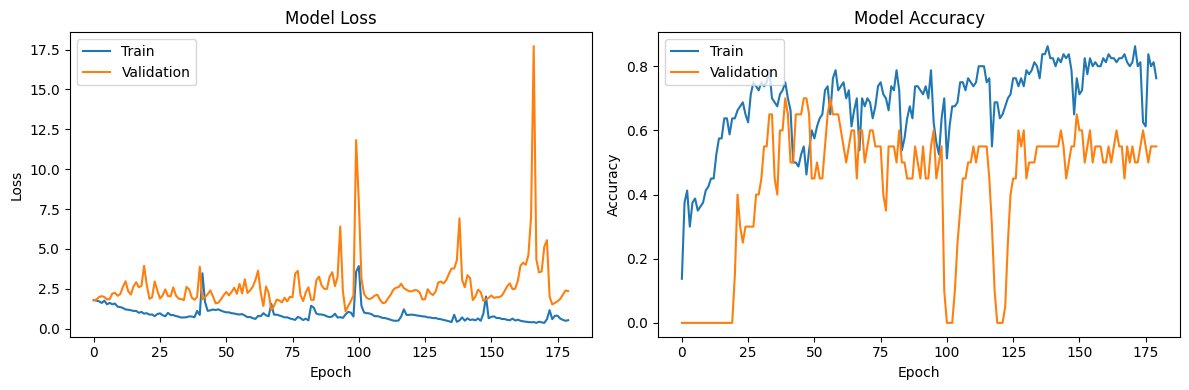

In [22]:
import matplotlib.pyplot as plt

def training_model(data_path, model_path):
    actions = get_actions(data_path) # ['word1', 'word2', 'word3]
    
    sequences, labels = get_sequences_and_labels(actions, data_path)
    
    sequences = pad_sequences(sequences, maxlen=MAX_LENGTH_FRAMES,padding='post', truncating='post', dtype='float32')

    X = np.array(sequences)
    y = to_categorical(labels).astype(int)
    
    model = get_model(len(actions))
    history = model.fit(X, y, epochs=NUM_EPOCH,validation_split=0.2)
    model.summary()
    model.save(model_path)

    plt.figure(figsize=(12, 4))
    
    # Plot training & validation loss values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
        
    # Plot training & validation accuracy values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')    
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    root = ROOT_PATH
    data_path = DATA_PATH
    save_path = os.path.join(root, "models")
    model_path = os.path.join(save_path, MODEL_NAME)
    
    training_model(data_path, model_path)

##### Evaluar modelo

In [12]:
def evaluate_model(model, threshold=0.7):
    count_frame = 0
    repe_sent = 1
    kp_sequence, sentence = [], []
    actions = get_actions(DATA_PATH)
    
    with Holistic() as holistic_model:
        video = cv2.VideoCapture(0)
        
        while video.isOpened():
            _, frame = video.read()

            image, results = mediapipe_detection(frame, holistic_model)
            kp_sequence.append(extract_keypoints(results))
            
            if len(kp_sequence) > MAX_LENGTH_FRAMES and there_hand(results):
                count_frame += 1
                
            else:
                if count_frame >= MIN_LENGTH_FRAMES:
                    res = model.predict(np.expand_dims(kp_sequence[-MAX_LENGTH_FRAMES:], axis=0))[0]

                    if res[np.argmax(res)] > threshold:
                        sent = actions[np.argmax(res)]
                        sentence.insert(0, sent)
                        #text_to_speech(sent)
                        sentence, repe_sent = format_sentences(sent, sentence, repe_sent)
                        
                    count_frame = 0
                    kp_sequence = []
            
            cv2.rectangle(image, (0,0), (640, 35), (245, 117, 16), -1)
            cv2.putText(image, ' | '.join(sentence), FONT_POS, FONT, FONT_SIZE, (255, 255, 255))
            
            draw_keypoints(image, results)
            cv2.imshow('GestureGuide', image)
            if cv2.waitKey(10) & 0xFF == ord('q'):
                break
                    
        video.release()
        cv2.destroyAllWindows()
    


In [13]:
if __name__ == "__main__":
    model_path = os.path.join(MODELS_PATH, MODEL_NAME)
    lstm_model = load_model(model_path)
    evaluate_model(lstm_model)


c:\Users\Admin\Desktop\Proyecto Final\IA\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━